In [3]:
import librosa
import librosa.display
import numpy as np
import utils.data_util as data_util
import matplotlib.pyplot as plt
from tensorflow.keras.applications import Xception, VGG16, ResNet50, ResNet101, ResNet152, ResNet50V2, ResNet101V2, ResNet152V2, InceptionV3
from tensorflow.keras.layers import Dense, Flatten, Concatenate
from tensorflow.keras import Model
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
import tensorflow.keras as keras

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print(gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Load Data

## Load file names

In [5]:
X_orig_audio, Y_orig_audio = data_util.load_audio_filenames()
X_orig_face, Y_orig_face = data_util.load_facial_filenames()

print(X_orig_audio.shape)
print(X_orig_face.shape)

hello
/home/reckoner1429/Documents/projects/video-emotion-recognition/data/RAVDESS/Audio_preprocessing_output
/home/reckoner1429/Documents/projects/video-emotion-recognition/data/RAVDESS/Video_preprocessing_output
(1440,)
(1440,)


## Split Data

In [6]:
# split data
print(X_orig_face.shape)
print(X_orig_audio.shape)

#Sanity check of the loaded data
for i in range(Y_orig_face.shape[0]):
    for j in range(Y_orig_face.shape[1]):
        if(not(Y_orig_face[i][j] == Y_orig_audio[i][j])):
            print("invalid1")
            break

# Split the data using train_test_split utility
train_test_distribution = train_test_split(X_orig_face, Y_orig_face, X_orig_audio, Y_orig_audio,
                                          test_size = 0.2, shuffle = True)
X_train_face = train_test_distribution[0]
X_test_face = train_test_distribution[1]
Y_train_face = train_test_distribution[2]
Y_test_face = train_test_distribution[3]

X_train_audio = train_test_distribution[4]
X_test_audio = train_test_distribution[5]
Y_train_audio = train_test_distribution[6]
Y_test_audio = train_test_distribution[7]

#Sanity check after splitting
for i in range(Y_test_face.shape[0]):
    for j in range(Y_test_face.shape[1]):
        if(not(Y_test_face[i][j] == Y_test_audio[i][j])):
            print("invalid")
            break

for i in range(Y_train_face.shape[0]):
    for j in range(Y_train_face.shape[1]):
        if(not(Y_train_face[i][j] == Y_train_audio[i][j])):
            print("invalid")
            break

#Y_train_face and Y_train_speech are equivalent
# and Y_test_face and Y_test_speech are also equivalent
Y_train = Y_train_face
Y_test = Y_test_face

(1440,)
(1440,)


## Define some parameters

In [7]:
INPUT_WIDTH = 224
INPUT_HEIGHT = 224
BATCH_SIZE = 8
epochs = 200

## Create the generators using filenames and labels

In [8]:
X_train_face_gen = data_util.FaceDataGenerator(X_train_face, Y_train_face, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)
X_val_face_gen = data_util.FaceDataGenerator(X_test_face, Y_test_face, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)

In [9]:
X_train_audio_gen = data_util.AudioDataGenerator(X_train_audio, Y_train_audio, BATCH_SIZE, INPUT_WIDTH, INPUT_WIDTH)
X_val_audio_gen = data_util.AudioDataGenerator(X_test_audio, Y_test_audio, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)

In [10]:
X_train_gen = data_util.MultimodalDataGenerator(X_train_face, X_train_audio, Y_train_face, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)
X_val_gen = data_util.MultimodalDataGenerator(X_test_face, X_test_audio, Y_test_face, BATCH_SIZE, INPUT_WIDTH, INPUT_HEIGHT)

# Pretrain the Model

## Define function to pretrain the model

In [11]:
base_model = Xception()
def pretrain(model, train_data_gen, val_data_gen, epochs, name):
    output_layer = Dense(8, activation = 'softmax')(model.layers[-2].output)
    model = Model(model.input, output_layer, name = 'pretrained_' + model.name + '_' + name + '_' + str(BATCH_SIZE))
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

    history = model.fit(train_data_gen, epochs = epochs)

    plt.plot(history.history['categorical_accuracy'])

    model_save_dir_path = './temp/saved_models/pretrained'
    if(not os.path.exists(model_save_dir_path)):
        os.makedirs(model_save_dir_path)
    model.save(model_save_dir_path + '/' + model.name + '.h5')

    model_history_path = './temp/history/pretrained'
    if(not os.path.exists(model_history_path)):
        os.makedirs(model_history_path)
    np.save(model_history_path + '/' + model.name + '_history.npy',history.history)

    model.evaluate(val_data_gen)

### Pretrain Audio and Facial Network

=============] - 26s 184ms/step - loss: 0.0677 - categorical_accuracy: 0.9766
Epoch 33/200
144/144 [==============================] - 26s 179ms/step - loss: 0.0903 - categorical_accuracy: 0.9757
Epoch 34/200
144/144 [==============================] - 26s 178ms/step - loss: 0.0847 - categorical_accuracy: 0.9740
Epoch 35/200
144/144 [==============================] - 25s 175ms/step - loss: 0.0770 - categorical_accuracy: 0.9800
Epoch 36/200
144/144 [==============================] - 26s 177ms/step - loss: 0.0983 - categorical_accuracy: 0.9705
Epoch 37/200
144/144 [==============================] - 25s 174ms/step - loss: 0.0802 - categorical_accuracy: 0.9774
Epoch 38/200
144/144 [==============================] - 25s 173ms/step - loss: 0.0658 - categorical_accuracy: 0.9792
Epoch 39/200
144/144 [==============================] - 25s 173ms/step - loss: 0.0522 - categorical_accuracy: 0.9826
Epoch 40/200
144/144 [==============================] - 25s 173ms/step - loss: 0.0550 - categorical_acc

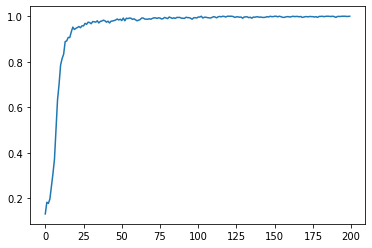

In [12]:
pretrain(base_model, X_train_face_gen, X_val_face_gen, epochs, 'face')

============] - 25s 176ms/step - loss: 0.0318 - categorical_accuracy: 0.9922
Epoch 35/200
144/144 [==============================] - 27s 185ms/step - loss: 0.0394 - categorical_accuracy: 0.9878
Epoch 36/200
144/144 [==============================] - 27s 186ms/step - loss: 0.0279 - categorical_accuracy: 0.9861
Epoch 37/200
144/144 [==============================] - 26s 178ms/step - loss: 0.0338 - categorical_accuracy: 0.9887
Epoch 38/200
144/144 [==============================] - 26s 177ms/step - loss: 0.0205 - categorical_accuracy: 0.9913
Epoch 39/200
144/144 [==============================] - 26s 178ms/step - loss: 0.0301 - categorical_accuracy: 0.9931
Epoch 40/200
144/144 [==============================] - 25s 176ms/step - loss: 0.0257 - categorical_accuracy: 0.9913
Epoch 41/200
144/144 [==============================] - 25s 177ms/step - loss: 0.0418 - categorical_accuracy: 0.9896
Epoch 42/200
144/144 [==============================] - 25s 176ms/step - loss: 0.0324 - categorical_accu

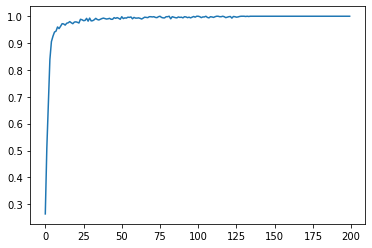

In [13]:
pretrain(base_model, X_train_audio_gen, X_val_audio_gen, epochs, 'audio')

# Train the Fusion Network

## Define the function for tranining

In [14]:
def train_fusion_network(ptrn_model_name, ptrn_face_batch_size, ptrn_audio_batch_size, X_train_gen, X_val_gen, epochs):
    model_face = keras.models.load_model('./temp/saved_models/pretrained/pretrained_' + ptrn_model_name + '_face_' + str(ptrn_face_batch_size) + '.h5')
    for layer in model_face.layers:
        layer._name = layer.name + '_face'
        layer.trainable = False
        output_layer_face = (model_face.layers[-2].output)
    
    model_audio = keras.models.load_model('./temp/saved_models/pretrained/pretrained_' + ptrn_model_name + '_audio_' + str(ptrn_audio_batch_size) + '.h5')
    for layer in model_audio.layers:
        layer._name = layer.name + '_audio'
        layer.trainable = False
    output_layer_audio = (model_audio.layers[-2].output)
    layer = Concatenate()([output_layer_face, output_layer_audio])
    layer = Dense(2048)(layer)
    layer = Dense(8, activation = 'softmax')(layer)
    model = Model([model_face.input, model_audio.input], layer, name = ptrn_model_name + '_' + str(ptrn_face_batch_size) + '_' + str(ptrn_audio_batch_size) + '_' + str(BATCH_SIZE))
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['categorical_accuracy'])

    history = model.fit(X_train_gen, epochs=epochs)

    model_save_dir_path = './temp/saved_models'
    if(not os.path.exists(model_save_dir_path)):
        os.makedirs(model_save_dir_path)
    model.save(model_save_dir_path + '/' + model.name + '.h5')

    model_history_path = './temp/history'
    if(not os.path.exists(model_history_path)):
        os.makedirs(model_history_path)
    np.save(model_history_path + '/' + model.name + '_history.npy',history.history)

    plt.plot(history.history['loss'])
    plt.plot(history.history['categorical_accuracy'])

    model.evaluate(X_val_gen)

poch 36/200
144/144 [==============================] - 11s 73ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 37/200
144/144 [==============================] - 11s 74ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 38/200
144/144 [==============================] - 11s 73ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 39/200
144/144 [==============================] - 11s 74ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 40/200
144/144 [==============================] - 11s 74ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 41/200
144/144 [==============================] - 11s 74ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 42/200
144/144 [==============================] - 11s 73ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 43/200
144/144 [==============================] - 11s 74ms/step - loss: 0.0000e+00 - categorical_accuracy: 1.0000
Epoch 44/200
144/144 [===================

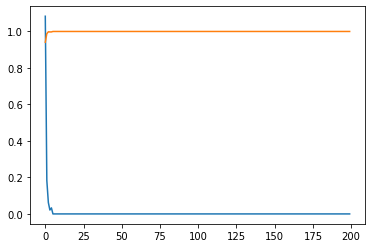

In [15]:
ptrn_face_batch_size = BATCH_SIZE
ptrn_audio_batch_size = BATCH_SIZE

train_fusion_network(base_model.name, ptrn_face_batch_size, ptrn_audio_batch_size, X_train_gen, X_val_gen, epochs)